In [34]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

In [35]:
data = np.load("C:/Users/logik/Desktop/rlsepsis234-master - full/data/processed_data.npz")

In [36]:
# used for gym environment
np.savez("sepsis_starting_states.npz", sepsis_starting_states = data['x_test'])

In [37]:
data.files

['x_train', 'y_train', 'x_test', 'y_test']

In [38]:
data['x_train'].shape   # 按之前一个文件应该是46，除非interval start and end 被换成episode length

(770139, 49)

In [39]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx % max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx],y_[idx]).all():     # [:-1] removed since we want full 49 columns for our model
            # episode changed
            episode = []
    return episode_matrix

In [40]:
train_matrix = get_padded_matrix(data['x_train'], data['y_train'])

In [41]:
train_matrix.shape      # 最大10个回合

(770139, 10, 49)

In [42]:
test_matrix = get_padded_matrix(data['x_test'], data['y_test'])

In [43]:
# model = tf.keras.Sequential([                 # LSTM
#     tf.keras.layers.LSTM(512, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(train_matrix.shape[2]-1)    # -1 removed?
# ])
model = tf.keras.Sequential([                 # GRU
    tf.keras.layers.GRU(512, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(train_matrix.shape[2])  # -1 shall be removed
])
# model = tf.keras.Sequential([                 # 双层LSTM
#     tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(64, return_sequences=False),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(train_matrix.shape[2]-1)
# ])
# from tensorflow.keras import layers
#
# class TransformerBlock(layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):     # dropout 0.1
#         super(TransformerBlock, self).__init__()
#         self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
#         self.ffn = tf.keras.Sequential([
#             layers.Dense(ff_dim, activation="relu"),
#             layers.Dense(embed_dim),
#         ])
#         self.layernorm1 = layers.LayerNormalization(epsilon=1e-2)
#         self.layernorm2 = layers.LayerNormalization(epsilon=1e-2)
#         self.dropout1 = layers.Dropout(rate)
#         self.dropout2 = layers.Dropout(rate)
#
#     def call(self, inputs, training):
#         attn_output = self.att(inputs, inputs)
#         attn_output = self.dropout1(attn_output, training=training)
#         out1 = self.layernorm1(inputs + attn_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output, training=training)
#         return self.layernorm2(out1 + ffn_output)
#
# embed_dim = 256  # Embedding size for each token
# num_heads = 4  # Number of attention heads
# ff_dim = 256  # Hidden layer size in feed forward network inside transformer
#
# inputs = layers.Input(shape=(10, 49)) # change to shape=(10, 49)
# embedding_layer = layers.TimeDistributed(layers.Dense(embed_dim))(inputs)  # replace the Embedding layer with a Dense layer wrapped in TimeDistributed
# transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block(embedding_layer)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.Dense(train_matrix.shape[2]-1)(x)
#
# model = tf.keras.Model(inputs=inputs, outputs=x)


In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 512)               864768    
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 49)                3185      
                                                                 
Total params: 900,785
Trainable params: 900,785
Non-trainable params: 0
_________________________________________________________________


In [45]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss='mean_squared_error')


In [46]:
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/lstm_no_embed{}".format(time()))
cp_callback = tf.keras.callbacks.ModelCheckpoint("C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model/sepsis_states.model",
                                                 verbose=1, monitor='val_loss', save_best_only=True)

early_stop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_matrix, data['y_train'], validation_data=(test_matrix, data['y_test']), epochs=10, callbacks=[tensorboard, cp_callback, early_stop], batch_size=512)

Epoch 1/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0725
Epoch 1: val_loss improved from inf to 0.06449, saving model to C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


1505/1505 [==============================] - 154s 101ms/step - loss: 0.0725 - val_loss: 0.0645
Epoch 2/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0627
Epoch 2: val_loss improved from 0.06449 to 0.06295, saving model to C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


1505/1505 [==============================] - 172s 114ms/step - loss: 0.0627 - val_loss: 0.0630
Epoch 3/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0618
Epoch 3: val_loss improved from 0.06295 to 0.06226, saving model to C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


1505/1505 [==============================] - 170s 113ms/step - loss: 0.0618 - val_loss: 0.0623
Epoch 4/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0613
Epoch 4: val_loss improved from 0.06226 to 0.06197, saving model to C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


1505/1505 [==============================] - 171s 114ms/step - loss: 0.0613 - val_loss: 0.0620
Epoch 5/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0610
Epoch 5: val_loss improved from 0.06197 to 0.06153, saving model to C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


1505/1505 [==============================] - 177s 118ms/step - loss: 0.0610 - val_loss: 0.0615
Epoch 6/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0607
Epoch 6: val_loss improved from 0.06153 to 0.06121, saving model to C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


1505/1505 [==============================] - 180s 119ms/step - loss: 0.0607 - val_loss: 0.0612
Epoch 7/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0604
Epoch 7: val_loss did not improve from 0.06121
1505/1505 [==============================] - 186s 123ms/step - loss: 0.0604 - val_loss: 0.0613
Epoch 8/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0602
Epoch 8: val_loss improved from 0.06121 to 0.06106, saving model to C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


1505/1505 [==============================] - 188s 125ms/step - loss: 0.0602 - val_loss: 0.0611
Epoch 9/10
1505/1505 [==============================] - ETA: 0s - loss: 0.0600
Epoch 9: val_loss did not improve from 0.06106
1505/1505 [==============================] - 175s 117ms/step - loss: 0.0600 - val_loss: 0.0612
Epoch 10/10
1504/1505 [============================>.] - ETA: 0s - loss: 0.0598
Epoch 10: val_loss improved from 0.06106 to 0.06084, saving model to C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


INFO:tensorflow:Assets written to: C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model\sepsis_states.model\assets


1505/1505 [==============================] - 183s 122ms/step - loss: 0.0598 - val_loss: 0.0608


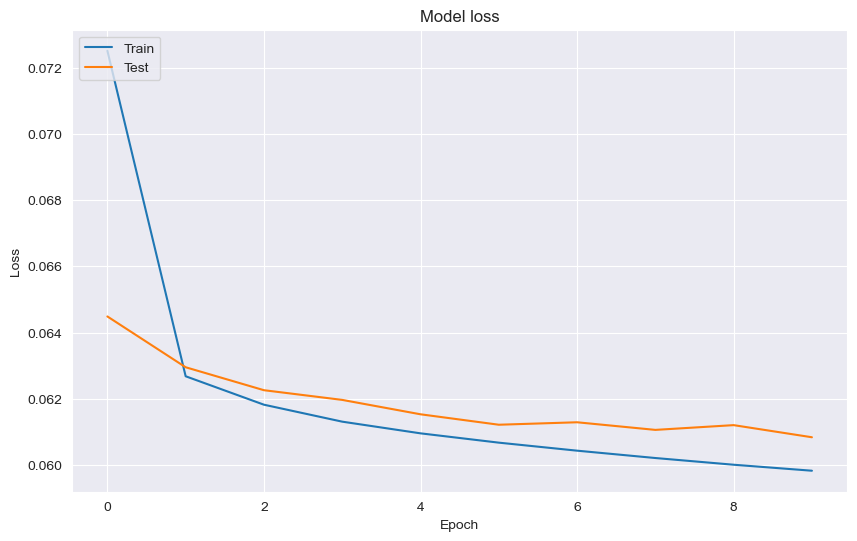

In [47]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# 使用test_predicted 10次

In [48]:
model = tf.keras.models.load_model("C:/Users/logik/Desktop/rlsepsis234-master - full/gym_sepsis/env/model/sepsis_states.model")     # 对齐上面目录

In [49]:
test_matrix.shape

(193284, 10, 49)

In [50]:
test_matrix[10,:,10]        #

array([0.21592443, 0.21659919, 0.23684211, 0.25506073, 0.23481781,
       0.22267206, 0.21052632, 0.21052632, 0.22267206, 0.22672065])

In [51]:
test_predicted = model.predict(test_matrix)

6041/6041 [==============================] - 51s 8ms/step


In [52]:
train_predicted = model.predict(train_matrix)

24067/24067 [==============================] - 191s 8ms/step


In [53]:
# columns = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
#        'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
#        'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
#        'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
#        'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
#        'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
#        'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
#        'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
#        'blood_culture_positive']
columns = ['Unnamed: 0', 'Admn001_ID', 'bloc', 'Demo002_Age',
       'Demo004_Elixhauser score', 'Demo005_Weight_kg', 'Vitl002_HR',
       'Vitl009_SOFA', 'Vitl003_SysBP', 'Vitl004_MeanBP', 'Vitl005_DiaBP',
       'Vitl006_RR', 'Labs001_Potassium', 'Labs002_sodium', 'Labs008_Ca',
       'Labs014_Albumin', 'Labs015_Hb', 'Labs021_pH', 'Labs024_BE',
       'Labs025_HCO3', 'Vitl011_Shock_Index',
       'Flud006_Cumulated fluid balance', 'Labs005_BUN', 'Labs006_Creatinine',
       'Labs013_TotalBili', 'Labs016_WbcCount', 'Labs017_PlateletsCount',
       'Labs027_PaO2_FiO2 ratio', 'Labs023_PaCO2', 'Labs026_Lactate',
       'Flud001_InputTotal', 'Flud004_OutputTotal', 'Flud005_Output4H',
       'Demo001_Gender_0', 'Demo001_Gender_1', 'Vent003_sedation_0',
       'Vent003_sedation_1', 'Flud007_rrt_0', 'Flud007_rrt_1',
       'Vent001_Mech_0', 'Vent001_Mech_1', 'Vitl010_SIRS_1', 'Vitl010_SIRS_2',
       'Vitl010_SIRS_3', 'Vitl010_SIRS_4', 'Vitl010_SIRS_5', 'Vitl001_GCS_3',
       'Vitl001_GCS_4', 'Vitl001_GCS_5', 'Vitl001_GCS_6', 'Vitl001_GCS_7',
       'Vitl001_GCS_8', 'Vitl001_GCS_9', 'Vitl001_GCS_10', 'Vitl001_GCS_11',
       'Vitl001_GCS_12', 'Vitl001_GCS_13', 'Vitl001_GCS_14', 'Vitl001_GCS_15',
       'Vitl007_SpO2_C0', 'Vitl007_SpO2_C1', 'Vitl007_SpO2_C2',
       'Vitl007_SpO2_C3', 'Vitl007_SpO2_C4', 'Vitl007_SpO2_C5',
       'Vitl007_SpO2_C6', 'Vitl007_SpO2_C7', 'Vitl007_SpO2_C8',
       'Vitl007_SpO2_C9', 'Vitl008_Temp_C0', 'Vitl008_Temp_C1',
       'Vitl008_Temp_C2', 'Vitl008_Temp_C3', 'Vitl008_Temp_C4',
       'Vitl008_Temp_C5', 'Vitl008_Temp_C6', 'Vitl008_Temp_C7',
       'Vitl008_Temp_C8', 'Vitl008_Temp_C9', 'vaso_input', 'iv_input',
       'discrete_action', 'reward', 'row_id', 'row_id_next',
       'OutC002_90d mortality', 'timeday']

In [54]:
test_predicted[0:11,columns.index('Vitl002_HR')]     # 11 used to be heart rate

array([0.19751795, 0.23220967, 0.27142334, 0.29266757, 0.31831616,
       0.332766  , 0.33626837, 0.34341365, 0.3446787 , 0.36118746,
       0.35715306], dtype=float32)

In [55]:
test_predicted[0:11,columns.index('Vitl003_SysBP')]

array([0.23538353, 0.27002406, 0.30154252, 0.33727336, 0.36309752,
       0.3582098 , 0.34978262, 0.34211105, 0.34177282, 0.35598236,
       0.36913335], dtype=float32)

In [56]:
# sns.set(style="white")
#
# def plot(column, mode="test", prediction=test_predicted):
#     from matplotlib.pyplot import figure
#     figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
#     plt.plot(data['y_'+mode][6:24,columns.index(column)].reshape(-1,2), label="truth", scaley=False)  # 不是之前的5：26
#     plt.plot(prediction[6:24,columns.index(column)].reshape(2,-1), label="predicted", scaley=False)
#     plt.ylim(-2, 2)
#     plt.legend(["Real Value", "Predicted (No VAE)"])
#     plt.title(column + " " + mode)
#     plt.show()

In [57]:
sns.set(style="white")

# def plot(column, mode="test", prediction=test_predicted):
#     from matplotlib.pyplot import figure
#     figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
#     plt.plot(data['x_'+mode][6:80,columns.index(column)], label="truth", scaley=False)          #　要求的数据是有两个索引，但是这些数据是一维的
#     plt.plot(prediction[6:80,columns.index(column)], label="predicted", scaley=False)
#     plt.ylim(-200, 200)
#     plt.legend(["Real Value", "Predicted (No VAE)"])
#     plt.title(column + " ")
#     plt.show()

def plot_and_validate(data_array, prediction_array, start, end, column):
    # Check if 'Demo002_Age' values are the same in the range
    age_col_index = columns.index("Demo002_Age")
    if np.unique(data_array[start:end, age_col_index]).size != 1:
        raise ValueError('you selected records from different patients')

    plt.plot(data_array[start:end, columns.index(column)], label="truth")
    plt.plot(prediction_array[start:end,columns.index(column)], label="predicted")
    plt.title(column)
    plt.legend(["Real Value", "Predicted Value"])
    plt.show()


In [58]:
print(test_predicted.shape)
test_predicted = pd.DataFrame(test_predicted)

(193284, 49)


In [59]:
data_array = np.array(data['x_'+"test"])
prediction_array = np.array(test_predicted)

plot_and_validate(data_array, prediction_array, 740, 760, 'Demo002_Age')

ValueError: you selected records from different patients

In [ ]:
import math
prediction_array[columns.index("Labs004_Glucose")] = math.e ** (prediction_array[columns.index("Labs004_Glucose")] * (6.90173720665657 - 0.693147180559945) + 0.693147180559945 ) -1
data_array[:,columns.index('Labs004_Glucose')] = math.e ** (data_array[:,columns.index('Labs004_Glucose')]* (6.90173720665657 - 0.693147180559945) + 0.693147180559945 )-1
plot_and_validate(data_array, prediction_array, 560, 565, 'Labs004_Glucose')

In [ ]:
# you need to descale manually tho
prediction_array[columns.index("Vitl004_MeanBP")] = prediction_array[columns.index("Vitl004_MeanBP")] * (200 - 0) + 0
data_array[:,columns.index('Vitl004_MeanBP')] = data_array[:,columns.index('Vitl004_MeanBP')] * (200 - 0) + 0

# Use the new plot function
plot_and_validate(data_array, prediction_array, 740, 760, 'Vitl004_MeanBP')

In [ ]:
# plot("Labs014_Albumin")
prediction_array[columns.index("Labs014_Albumin")] = prediction_array[columns.index("Labs014_Albumin")] * (5.9 - 1) + 1
data_array[:,columns.index('Labs014_Albumin')] = data_array[:,columns.index('Labs014_Albumin')] * (5.9 - 1) + 1
if np.unique(data_array[740:760, columns.index("Demo002_Age")]).size != 1:
    raise ValueError('you selected records from different patients')

plt.plot(data_array[740:760,columns.index("Labs014_Albumin")], label="truth")
plt.plot(prediction_array[740:760,columns.index("Labs014_Albumin")], label="predicted")
plt.legend(["Real Value", "Predicted (No VAE)"])

In [ ]:
plot("Labs016_WbcCount")

In [ ]:
plot("Labs002_sodium")

In [ ]:
plot("Labs001_Potassium")

In [ ]:
plot("Labs003_chloride")

In [ ]:
plot("Vitl002_HR")